In [3]:
import re
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
import yfinance as yf
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:


# ── Model ──────────────────────────────────────────────────────────────────────
model = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.7,
    max_tokens=500
)

# ── State ──────────────────────────────────────────────────────────────────────
class StockState(TypedDict):
    query: str
    search_result: list
    tickers: list
    positive_stocks: list

# ── Tools ──────────────────────────────────────────────────────────────────────
search_tool = TavilySearchResults(max_results=5)

# ── Nodes ──────────────────────────────────────────────────────────────────────
def search_stocks(state: StockState):
    results = search_tool.invoke({"query": state["query"]})
    print(f"🔍 Search returned {len(results)} results")
    return {"search_result": results}


def extract_tickers(state: StockState):
    content = str(state['search_result'])

    # Extract ticker symbols directly using regex (2-5 uppercase letters)
    raw_tickers = re.findall(r'\b([A-Z]{2,5})\b', content)

    # Filter out common false positives
    blacklist = {
        "USD", "TTM", "YOY", "EPS", "DIV", "ETF", "NYSE", "NASDAQ",
        "SEC", "CEO", "CFO", "IPO", "API", "URL", "AI", "US", "PE",
        "AM", "PM", "EST", "THE", "FOR", "AND", "INC", "LLC", "LTD",
        "AVG", "VOL", "BUY", "SELL", "STRONG", "NO", "MKT", "NA",
        "NaN", "SIGN", "TOP", "NEW", "OLD", "HIGH", "LOW", "NET",
        "COM", "ORG", "HTML", "JSON", "HTTP", "HTTPS", "GET", "POST"
    }

    # Deduplicate while preserving order
    seen = set()
    tickers = []
    for t in raw_tickers:
        if t not in blacklist and t not in seen:
            seen.add(t)
            tickers.append(t)

    print(f"✅ Extracted {len(tickers)} tickers: {tickers}")
    return {"tickers": tickers}


def check_positive_stocks(state: StockState):
    positive = []

    for ticker in state["tickers"]:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period="5d")

            if hist.empty or len(hist) < 2:
                print(f"⚠️  {ticker}: Not enough data")
                continue

            closes = hist["Close"].dropna()

            if len(closes) < 2:
                continue

            yesterday = closes.iloc[-2]
            today = closes.iloc[-1]

            if yesterday <= 0:
                continue

            percent_change = ((today - yesterday) / yesterday) * 100
            print(f"📊 {ticker}: {yesterday:.2f} → {today:.2f} ({percent_change:.2f}%)")

            if percent_change > 0:
                positive.append({
                    "ticker": ticker,
                    "yesterday_close": round(float(yesterday), 2),
                    "today_close": round(float(today), 2),
                    "absolute_increase": round(float(today - yesterday), 2),
                    "percent_increase": round(float(percent_change), 2)
                })

        except Exception as e:
            print(f"❌ Error for {ticker}: {e}")
            continue

    return {"positive_stocks": positive}

builder = StateGraph(StockState)

builder.add_node("search", search_stocks)
builder.add_node("extract", extract_tickers)
builder.add_node("check", check_positive_stocks)

builder.set_entry_point("search")

builder.add_edge("search", "extract")
builder.add_edge("extract", "check")
builder.add_edge("check", END)

graph = builder.compile()


result = graph.invoke({
    "query": "Top stocks increasing today in US market"
})

print("\n" + "="*50)
print("📈 Stocks Showing Positive Growth:")
print("="*50)

if not result["positive_stocks"]:
    print("No positive stocks found. Market may be closed or data unavailable.")
else:
    for stock in sorted(result["positive_stocks"], key=lambda x: x["percent_increase"], reverse=True):
        print(f"\n  Ticker   : {stock['ticker']}")
        print(f"  Yesterday: ${stock['yesterday_close']}")
        print(f"  Today    : ${stock['today_close']}")
        print(f"  Change   : +${stock['absolute_increase']} (+{stock['percent_increase']}%)")

print("\n" + "="*50)
print(f"✅ Total positive stocks found: {len(result['positive_stocks'])}")

/home/lang-chain/miniconda3/envs/Agentic_AI_MCP_RAG_Chat/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
/tmp/ipykernel_62794/3848189600.py:24: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=5)


🔍 Search returned 5 results
✅ Extracted 32 tickers: ['USAUU', 'AAOI', 'ARLO', 'BWIN', 'FIGS', 'DELL', 'AAL', 'PSKY', 'EOSE', 'INTC', 'BAC', 'NVDA', 'NFLX', 'NU', 'SOFI', 'MARA', 'CRM', 'SHOP', 'ZS', 'AMZN', 'AWS', 'MSFT', 'GOOG', 'GOOGL', 'BRK', 'GEICO', 'AAPL', 'CVX', 'AXP', 'KO', 'DIS', 'WSJ']


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: USAUU"}}}
$USAUU: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


⚠️  USAUU: Not enough data
📊 AAOI: 53.69 → 84.23 (56.88%)
📊 ARLO: 12.34 → 15.69 (27.15%)
📊 BWIN: 18.49 → 23.23 (25.64%)
📊 FIGS: 12.47 → 15.45 (23.90%)
📊 DELL: 121.45 → 148.08 (21.93%)
📊 AAL: 13.94 → 13.07 (-6.24%)
📊 PSKY: 11.18 → 13.51 (20.84%)
📊 EOSE: 6.74 → 5.70 (-15.50%)
📊 INTC: 45.46 → 45.61 (0.33%)
📊 BAC: 52.30 → 49.83 (-4.72%)
📊 NVDA: 184.89 → 177.19 (-4.16%)
📊 NFLX: 84.59 → 96.24 (13.77%)
📊 NU: 15.06 → 14.98 (-0.53%)
📊 SOFI: 19.10 → 17.76 (-7.02%)
📊 MARA: 8.45 → 8.94 (5.80%)
📊 CRM: 199.47 → 194.79 (-2.35%)
📊 SHOP: 125.94 → 120.73 (-4.14%)
📊 ZS: 167.36 → 146.99 (-12.17%)
📊 AMZN: 207.92 → 210.00 (1.00%)


$AWS: possibly delisted; no price data found  (period=5d)


⚠️  AWS: Not enough data
📊 MSFT: 401.72 → 392.74 (-2.24%)
📊 GOOG: 307.15 → 311.43 (1.39%)


$BRK: possibly delisted; no price data found  (period=5d)


📊 GOOGL: 307.38 → 311.76 (1.42%)
⚠️  BRK: Not enough data


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: GEICO"}}}
$GEICO: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


⚠️  GEICO: Not enough data
📊 AAPL: 272.95 → 264.18 (-3.21%)
📊 CVX: 184.16 → 186.76 (1.41%)
📊 AXP: 335.32 → 308.90 (-7.88%)
📊 KO: 80.50 → 81.56 (1.32%)


$WSJ: possibly delisted; no price data found  (period=5d)


📊 DIS: 105.55 → 106.04 (0.46%)
⚠️  WSJ: Not enough data

📈 Stocks Showing Positive Growth:

  Ticker   : AAOI
  Yesterday: $53.69
  Today    : $84.23
  Change   : +$30.54 (+56.88%)

  Ticker   : ARLO
  Yesterday: $12.34
  Today    : $15.69
  Change   : +$3.35 (+27.15%)

  Ticker   : BWIN
  Yesterday: $18.49
  Today    : $23.23
  Change   : +$4.74 (+25.64%)

  Ticker   : FIGS
  Yesterday: $12.47
  Today    : $15.45
  Change   : +$2.98 (+23.9%)

  Ticker   : DELL
  Yesterday: $121.45
  Today    : $148.08
  Change   : +$26.63 (+21.93%)

  Ticker   : PSKY
  Yesterday: $11.18
  Today    : $13.51
  Change   : +$2.33 (+20.84%)

  Ticker   : NFLX
  Yesterday: $84.59
  Today    : $96.24
  Change   : +$11.65 (+13.77%)

  Ticker   : MARA
  Yesterday: $8.45
  Today    : $8.94
  Change   : +$0.49 (+5.8%)

  Ticker   : GOOGL
  Yesterday: $307.38
  Today    : $311.76
  Change   : +$4.38 (+1.42%)

  Ticker   : CVX
  Yesterday: $184.16
  Today    : $186.76
  Change   : +$2.6 (+1.41%)

  Ticker   : GOOG

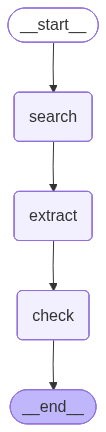

In [ ]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))